data shape:  (10240, 2)
G1: [     0.      0.      0. ...  29980. -11983.  22466.]
G2: [     0.      0.      0. ...  32834. -85453.  16812.]
G len: 5120
G [     0.    +0.j      0.    +0.j      0.    +0.j ...  29980.+32834.j
 -11983.-85453.j  22466.+16812.j]
------------------
T: [0.0000e+00 3.0000e-06 6.0000e-06 ... 1.5351e-02 1.5354e-02 1.5357e-02]
T len: 5120
bb: (1008.0458536585365-1376.4526829268293j)
frequency: [  0.          16.27604167  32.55208333 ... -48.828125   -32.55208333
 -16.27604167]
abs CDFT: [56865113.63521335 70964131.8734719  82794789.21294235 ...
 25144321.64334526 32584148.86448318 43285799.07025246]


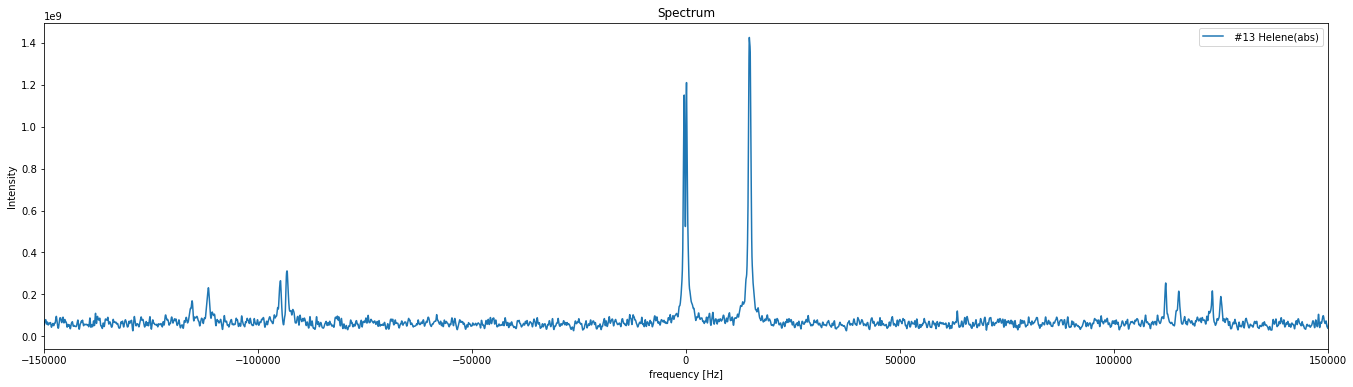

Parameters:
Sample: Helene
File Name: 13
Number of Scans: 2093
Dwell Time: 3e-06s
Size of FT: 20480
Start Time: 0.0s
Phase: 0.0
Broadening Factor: 100
Adopization window: None


In [2]:
import nmrglue as ng
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.fft import fft
from scipy.fftpack import fftfreq
import pandas as pd
from scipy.signal import convolve


# Load data from file
array = np.loadtxt('13DW1.5NS2093.txt', delimiter=',')
   
       
# Convert to NumPy array
array = np.array(array)

# Verify the array dimensions
print("data shape: ", array.shape)  # Output: (rows, cols) 



# Extract real and imaginary components of the data

# select the first column of the array
col_1 = array[:, 1]

# create arrays G1 and G2 for even and odd rows respectively
G1 = col_1[::2]  # start from index 0 and step by 2
G2 = col_1[1::2]  # start from index 1 and step by 2

# print the result
print("G1:", G1)
print("G2:", G2)

# create a new array G with complex numbers
G = G1 + 1j*G2

# print the result
print("G len:", len(G))
real_part= G1
imaginary_part= G2


print("G",G)
print("------------------")


# Create time array

dwell_time = 3e-6

T = np.arange(len(G))*dwell_time

print("T:", T)
print("T len:", len(T))



## CUT PART OF TIME ------ Baseline correction 
# Assuming you have the arrays T and G
start_time = 0.000

# Find the index corresponding to the start time
start_index = int(start_time / dwell_time)

# Cut array T from the start index ---------------------*****
T_cut = T[start_index:]

# Cut array G from the corresponding start index -------*****
G_cut = G[start_index:]



# ----------------- Baseline subtraction

le2 = len(G_cut)

base = round(le2/5)
bb = np.mean(G_cut[(le2-base-1):])
G_bb = G_cut - bb

print("bb:", bb) #should be a complex number




# ---------------------------------------- Before FT transform Processes --------------
szft = 10*2048

t2g = 1000e-6

# ---------------- 
# Generate the frequency axis
frequency = np.fft.fftfreq(szft, d=(T_cut[1] - T_cut[0]))
print("frequency:", frequency) 





# ------------------------- phase correction

phase = 0/180*np.pi #changing x in x/180*np.pi changes the phase in real FT

# Apply phase correction 
G_bb_phcor = G_bb*np.exp(-1j*phase)




# ------------------------- Apodization

#G_bb_phcor_adop= G_bb_phcor *np.exp(-T_cut**2/2/t2g**2)  # gaussian
#G_bb_phcor_adop =  G_bb_phcor *np.blackman(len(G_bb))   # blackman


# -------------------------------------------------------- FOURIER Transform
# Compute the Complex Discrete Fourier Transform (CDFT)
cdft_processed = fft(G_bb_phcor,n=szft)



abs_CDFT_processed = np.abs(cdft_processed) #------ REAL -----#
print("abs CDFT:", abs_CDFT_processed) 

# ---------------------------------------------------------  Ordering Data

# Since DATA IS NOT ORDERED, PANDAS IS USED TO ORDER THEM
# Create DataFrame from arrays
datax = pd.DataFrame({'frequency': frequency, 'abs_CDFT_processed': abs_CDFT_processed})

# Sort DataFrame based on 'frequency' column
FIN_ord_abs_spectrum2d = datax.sort_values(by='frequency', ascending=False)


# Separate the data AGAIN cuz I like dealing with two arrays
frequency = FIN_ord_abs_spectrum2d['frequency'].values  # Extracts the 'frequency' column as a NumPy array
abs_spectrum = FIN_ord_abs_spectrum2d['abs_CDFT_processed'].values  # Extracts the 'abs_CDFT_processed' column as a NumPy array



# ---------------------------------------------- Line Broadening process

# Broadening function
broadening_factor = 100
broadening_function = np.exp(-frequency ** 2 / (2 * broadening_factor ** 2))

# Perform line broadening using convolution
broadened_abs_spectrum = convolve(abs_spectrum, broadening_function, mode='same')


# -------------------------------------------------- Blotting

# Plot the original and broadened spectra
plt.figure(6,figsize=(23,6))
#plt.plot(frequency, abs_spectrum, label='Original Spectrum')
plt.plot(frequency,  broadened_abs_spectrum , label=(' #13 Helene(abs)'))
plt.legend()
# Zoom in
plt.xlim(-150000, 150000)
plt.xlabel('frequency [Hz]')
plt.ylabel('Intensity')
plt.title('Spectrum')
# Draw a vertical line at x = 
#plt.axvline(x=-1220, color='r', linestyle='--')
#plt.axvline(x=-1420, color='r', linestyle='--')
#plt.axvline(x=-1520, color='r', linestyle='--')
#plt.axvline(x=-1720, color='r', linestyle='--')

#plt.axvline(x=-12520, color='r', linestyle='--')
#plt.axvline(x=-12260, color='r', linestyle='--')
#plt.axvline(x=-1220, color='r', linestyle='--')
#plt.axvline(x=-1220, color='r', linestyle='--')

#plt.axvline(x=-1220, color='r', linestyle='--')
#plt.axvline(x=-1220, color='r', linestyle='--')
#plt.axvline(x=-1220, color='r', linestyle='--')
#plt.axvline(x=-1220, color='r', linestyle='--')


# Save the plot as a PDF file
#plt.savefig('plot.png')
plt.show()


# Combine print and save codes
parameters_str = f"Parameters:\n\
Sample: Helene\n\
File Name: 13\n\
Number of Scans: 2093\n\
Dwell Time: {dwell_time}s\n\
Size of FT: {szft}\n\
Start Time: {start_time}s\n\
Phase: {phase*180/np.pi}\n\
Broadening Factor: {broadening_factor}\n\
Adopization window: None"

# Print parameter values
print(parameters_str)

# Save parameter values to a file
with open("parameters.txt", "w") as file:
    file.write(parameters_str)




# ----------------------------- ----------- SAVE DATA
#Spectrum in a txt file
c1 = frequency
c2 = broadened_abs_spectrum
# Open the file in write mode
with open('null.txt', 'w') as file:
    # Iterate over the elements of c1, c2 and y simultaneously
    for a, b in zip(c1, c2):
        # Write each pair of values as a line in the file
        file.write(f'{a}\t{b}\n')
  

In [ ]:
 #-------------------------------------------------- Blotting

# Plot the original and broadened spectra
plt.figure(6,figsize=(10,6))
#plt.plot(frequency, abs_spectrum, label='Original Spectrum')
plt.plot(frequency,  broadened_abs_spectrum , label=(' #113 Helene(abs)'))
plt.legend()
# Zoom in
plt.xlim(105000, 130000)
plt.xlabel('frequency [Hz]')
plt.ylabel('Intensity')
plt.title('Spectrum')
#plt.axvline(x=15042.55, color='r', linestyle='--')
# Save the plot as a PDF file
#plt.savefig('plot.png')
plt.show()


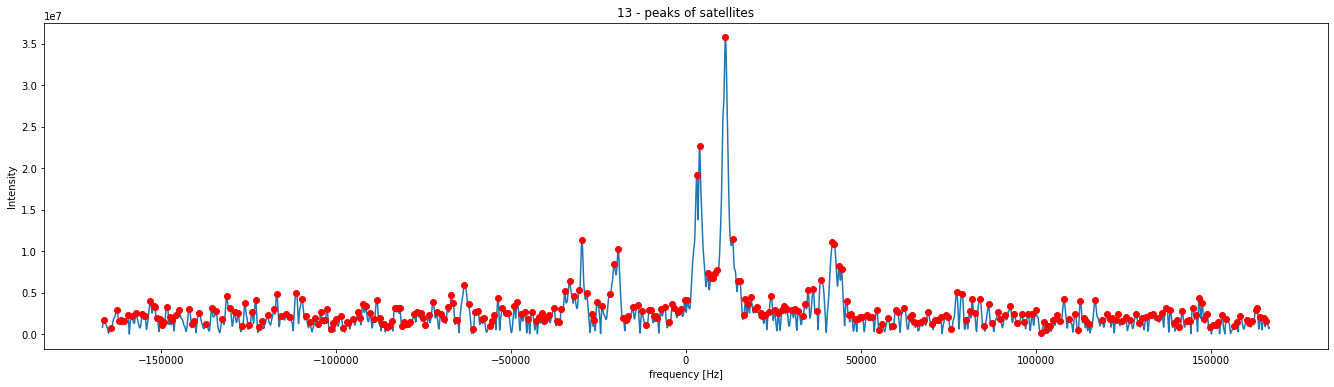

In [162]:
# ---------PEAKS SELECTION ------------
from scipy.signal import find_peaks

# Create an example array
x = frequency
y = broadened_abs_spectrum

# Find the peaks
peaks, _ = find_peaks(y)

# Get the x values corresponding to the peaks
x_peaks = x[peaks]

# Get the x values corresponding to the peaks
Freq_peaks = frequency[peaks]

#print(Freq_peaks)

# Plot the curve and the peak points
plt.figure(5,figsize=(23,6))
plt.plot(x, y)
plt.plot(x_peaks, y[peaks], "ro")
plt.title('13 - peaks of satellites')
# Zoom in
#plt.xlim(100000, 150000)
plt.xlabel('frequency [Hz]')
plt.ylabel('Intensity')
plt.show()


Peaks frequencies:
[11295.57291667  3906.25        3092.44791667]


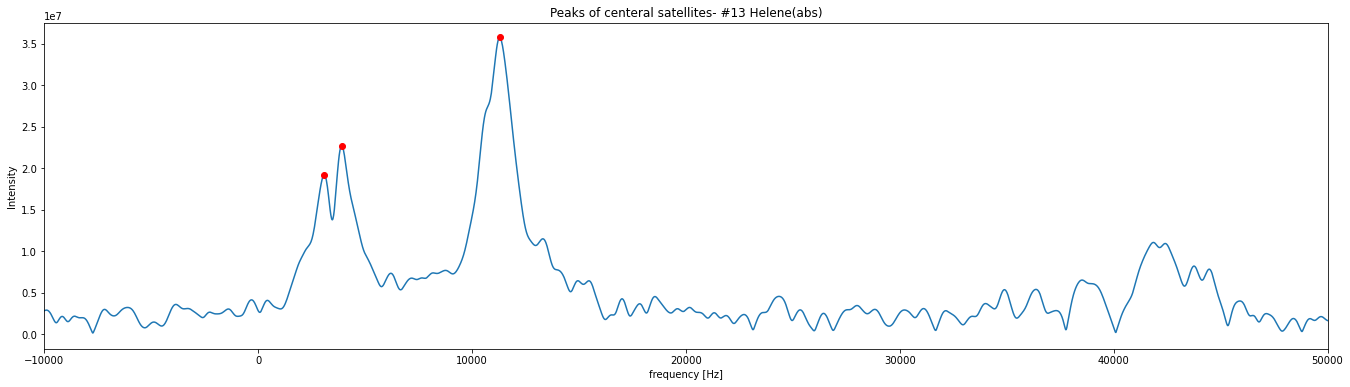

In [158]:
# Set the minimum peak value
min_peak_value =1.5e7

# Get the x values corresponding to the peaks with y values greater than min_peak_value
selected_peaks = peaks[y[peaks] > min_peak_value]
x_selected_peaks = x[selected_peaks]

print("Peaks frequencies:")
print(x_selected_peaks)

# Plot the curve and the selected peak points
plt.figure(6,figsize=(23,6))
plt.plot(x, y, label=(' #13 Helene(abs)'))
plt.plot(x_selected_peaks, y[selected_peaks], "ro")
plt.title('Peaks of centeral satellites- #13 Helene(abs)')
# Draw a vertical line at x = 5000
#plt.axvline(x=-1220, color='r', linestyle='--')

# Zoom in
plt.xlim(-10000, 50000)
plt.xlabel('frequency [Hz]')
plt.ylabel('Intensity')
plt.show()

Peaks frequencies:
[39420.57291667 37955.72916667 36523.4375     35530.59895833]


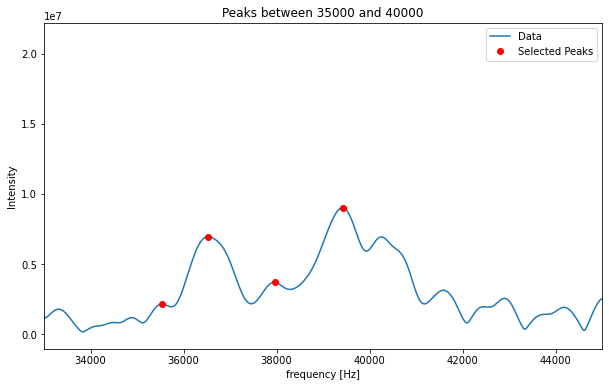

In [131]:
import numpy as np
import matplotlib.pyplot as plt


# Set the range of x values to consider for peak detection
x_start = 35000
x_end = 40000

# Get the indices of data points within the specified x range
x_indices_within_range = np.where((x >= x_start) & (x <= x_end))[0]

# Find peaks within the specified x range
peaks, _ = find_peaks(y[x_indices_within_range])

# Get the x values corresponding to the peaks
x_selected_peaks = x[x_indices_within_range][peaks]

print("Peaks frequencies:")
print(x_selected_peaks)

# Plot the curve and the selected peak points
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Data')
plt.plot(x_selected_peaks, y[x_indices_within_range][peaks], "ro", label='Selected Peaks')
plt.title('Peaks between {} and {}'.format(x_start, x_end))
plt.xlabel('frequency [Hz]')
plt.ylabel('Intensity')
#Zoom in
plt.xlim(33000, 45000)
plt.legend()
plt.show()
